# A randomized experiment to measure the significance of a startup name 
### Jason Sanchez - Kevin Dugan - Manish Sannat
### W241-2 
### Summer'16

## Libraries to use

In [1]:
options(digits=3) 
options(warn=-1)

In [2]:
library(lmtest)
library(sandwich)
library(multiwayvcov)
library(data.table)
library(stargazer)
library(lmtest)
library(reshape2)
library(ggplot2)
library(repr)
library(wordcloud)
library(tm)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Please cite as: 

 Hlavac, Marek (2015). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2. http://CRAN.R-project.org/package=stargazer 


Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt

Loading required package: RColorBrewer
Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate



## Power Calculations

1. Read in the original pilot study data to determine % qualifiers passed.
2. Read in a cleaned, reshaped set of data. This data has removed the failed qualifiers.
3. Establish a power calculator function. Test with data from FE pg 93.
4. Conduct analysis of control vs nonsense names
5. Conduct analysis of control vs terrible names
6. Average Treatment Effect is set at .5
6. $\alpha$ will be set at .05
7. Power will be $\ge$ .8

#### Methods used to increase power in simulations
1. Manipulated sample size.

### Results summary:

__Bottom line: Minimum of 130 surveys needed__

Use the % of bad qualifiers from the data - 77%

While we hit 80% power at 400 actual surveys taken, need to take into account the number of subjects who do not pass the qualifiers. Assuming that is still approximately 77%, we get the following results:

1. Control v. Nonsense: $\frac{400}{.77} = 519$ (round to 520)

2. Control v. Terrible: $\frac{400}{.77} = 519$ (round to 520)

This would be 780 observations (260 * 3). Given there are 6 questions per survey, we can calculate that to be $\frac{780}{6} = 130$ subjects needed. 

__For us to detect an ATE of .5 at a 95% confidence level 80% of the time we ran this experiment, we would need at least 130 surveys (780 rating data points)__.

## Power Calculation Function

In [3]:
# read in the cleaned, reshaped data set
pilot.data <- data.table(read.csv("final_test_data_rs.csv"))

# power calculator function. Given ATE, sigma, alpha, and N,
# calculates the power.
power_calculator <- function(ate=.5, sigma, alpha=0.05, N) { 

    lowertail <- (abs(ate)*sqrt(N))/(2*sigma) 
    uppertail <- -1*lowertail 
    beta <- pnorm(lowertail- qnorm(1-alpha/2), lower.tail=TRUE) + 
        1- pnorm(uppertail- qnorm(1-alpha/2), lower.tail=FALSE) 
    return(beta) 
}

# function check - inputs are from FE, pg 93. Result = .80 as per book.
print(paste('Power should be .8. Result = ', 
            round(power_calculator(5, 20, .05, 500), digits=2)))

good.quals <- .77

[1] "Power should be .8. Result =  0.8"


## Sample Size Calculation Function

In [4]:
# read in the data into its separate groups of control name, nonsense name
control.data <- pilot.data[treatment == 0]
treat1.data <- pilot.data[treatment == 1]
treat2.data <- pilot.data[treatment == 2]

# sample sizes to test
sample_sizes <- seq(from=375, to=425, by=25)

# function to calculate power for a randomized sampling of data
betas <- function(sampl, control, treat, f){ 
        
    # sample from the control subset
    x <- control[sample(1:nrow(control), size=sampl, 
                            replace=TRUE)]
    

    # use pooled sd for the rating by funding category
    sigma_x <- sqrt((var(x[funding_id == 0]$rating) +
             var(x[funding_id == 1]$rating) +
             var(x[funding_id == 2]$rating) +
             var(x[funding_id == 4]$rating) +
             var(x[funding_id == 5]$rating) +
             var(x[funding_id == 6]$rating) +
             var(x[funding_id == 7]$rating)) / 7) 

    # get number of rows in control sample
    n_x <- nrow(x)
    
    # sample the treatment 1 (nonsense name) dataset
    y <- treat[sample(1:nrow(treat), size=sampl, 
                            replace=TRUE)]
    
    # use pooled sd for the rating by funding category
    sigma_y <- sqrt((var(y[funding_id == 0]$rating) +
             var(y[funding_id == 1]$rating) +
             var(y[funding_id == 2]$rating) +
             var(y[funding_id == 3]$rating) +
             var(y[funding_id == 4]$rating) +
             var(y[funding_id == 6]$rating) +
             var(y[funding_id == 7]$rating)) / f)
    
    # calculate the avg std deviation for the formula
    sigma <- mean(sigma_x, sigma_y)
    
    # get number of rows in nonsense name group
    n_y <- nrow(y)
    
    # number of total rows
    n <- n_x + n_y
    
    # calculate power
    ctl_trt <- power_calculator(sigma = sigma, N=n)
    
    # return the beta (power) value
    ctl_trt
}

# test sample size calculations function to be sure it does not error out
if (round(betas(100, control.data, treat1.data, 7), 3) >= 0){
    print(paste('Sample size function check passed'))
} else {
    print(paste('Sample size function check failed'))
}

[1] "Sample size function check passed"


## Power & Sample Size Calculations

### Actual and Nonsense Names

In [5]:
for (sampl in sample_sizes){
    
    print(paste('Sample size: ', sampl))

    f <- 7 # number of funding levels present in pilot study for treatment
    beta_sims <- replicate(1000, betas(sampl, control.data, treat1.data, f))
        
    print(paste('Avg Power Calc: ', mean(beta_sims)))
        
    sample_size_needed = sampl / good.quals
    print(paste('Sample size needed factoring in % bad qualifying answers: ',
                round(sample_size_needed, digits = 0)))

    cat('\n')
}

[1] "Sample size:  375"
[1] "Avg Power Calc:  0.788224054635434"
[1] "Sample size needed factoring in % bad qualifying answers:  487"

[1] "Sample size:  400"
[1] "Avg Power Calc:  0.812868036781088"
[1] "Sample size needed factoring in % bad qualifying answers:  519"

[1] "Sample size:  425"
[1] "Avg Power Calc:  0.836730652478354"
[1] "Sample size needed factoring in % bad qualifying answers:  552"



### Actual and Terrible Names

In [6]:
for (sampl in sample_sizes){
    
    print(paste('Sample size: ', sampl))

    f <- 8
    beta_sims <- replicate(1000, betas(sampl, control.data, treat2.data, f))
        
    print(paste('Avg Power Calc: ', mean(beta_sims)))
        
    sample_size_needed = sampl / good.quals
    print(paste('Sample size needed factoring in % bad qualifying answers: ',
                round(sample_size_needed, digits = 0)))

    cat('\n')
}

[1] "Sample size:  375"
[1] "Avg Power Calc:  0.788346884513571"
[1] "Sample size needed factoring in % bad qualifying answers:  487"

[1] "Sample size:  400"
[1] "Avg Power Calc:  0.813285591184791"
[1] "Sample size needed factoring in % bad qualifying answers:  519"

[1] "Sample size:  425"
[1] "Avg Power Calc:  0.83576237269183"
[1] "Sample size needed factoring in % bad qualifying answers:  552"



## Loading and cleaning the dataset

In [7]:
# read survey result csv file and store it into a data frame
sim.dataset <- read.csv("W241 - Startup name tests_August 1, 2016_19.42.csv")

# remove header
sim.dataset <-sim.dataset[-1,]

# remove empty ratings
sim.dataset <- sim.dataset[ (sim.dataset$QID24!="" | sim.dataset$QID25!="" | sim.dataset$QID28!="" | sim.dataset$QID29!="" | sim.dataset$QID30!="" | sim.dataset$QID31!="") , ]

# remove empty rows(if any)
sim.dataset <- sim.dataset[!apply(sim.dataset == "", 1, all),]

# remove incorrect qualifying questions
sim.dataset <- sim.dataset[ (sim.dataset$QID2 == "3") , ]
sim.dataset <- sim.dataset[ (sim.dataset$QID3 == "Wednesday") , ]
sim.dataset <- sim.dataset[ (sim.dataset$QID4 == "Obama") , ]

# convert data frame to data table for further data transformation and analysis
sim.dataset <- data.table(sim.dataset)

# remove extra charactes from ratings and convert it to numeric
sim.dataset <-sim.dataset[, QID24 := as.integer(as.character(trimws(substring(QID24, 0, 2))))]
sim.dataset <-sim.dataset[, QID25 := as.integer(as.character(trimws(substring(QID25, 0, 2))))]
sim.dataset <-sim.dataset[, QID28 := as.integer(as.character(trimws(substring(QID28, 0, 2))))]
sim.dataset <-sim.dataset[, QID29 := as.integer(as.character(trimws(substring(QID29, 0, 2))))]
sim.dataset <-sim.dataset[, QID30 := as.integer(as.character(trimws(substring(QID30, 0, 2))))]
sim.dataset <-sim.dataset[, QID31 := as.integer(as.character(trimws(substring(QID31, 0, 2))))]
sim.dataset <-sim.dataset[, duration := as.integer(as.character(trimws(duration)))]

# remove 5% fastest and 5% slowest respondents
sim.datasettop5 <-sim.dataset[duration > quantile(duration,prob=1-5/100) ,]
sim.datasetbottom5 <-sim.dataset[duration < quantile(duration,prob=5/100) ,]
sim.dataset <- subset(sim.dataset, !duration  %in% (sim.datasettop5$duration))
sim.dataset <- subset(sim.dataset, !duration  %in% (sim.datasetbottom5$duration))

# remove survey taken before --> Yes
sim.dataset <- sim.dataset[ (sim.dataset$QID50!="Yes") , ]

# remove observations for: when asked to recall the startups, picked at least 4 startups but no more than 10 from the list 
# and got more than 50% of the ones picked correct.

sim.dataset <- sim.dataset[ , QID40 :=  as.character(trimws(QID40))  ]
sim.dataset <- sim.dataset[ , startup.names := paste(  as.character(trimws(appboy_name)), as.character(trimws(teespring_name)), as.character(trimws(lystable_name)), 
                                                       as.character(trimws(lendup_name)), as.character(trimws(homey_name)), as.character(trimws(bitgym_name)), sep= "," ) ]


sim.dataset <- sim.dataset[ , recall.indicator :=  ifelse ( ( length(unlist(strsplit(QID40, ","))) >= 4  & length(unlist(strsplit(QID40, ","))) <=10  &
                                                                 ( (    sum(is.element(unlist(strsplit(startup.names, ",")), unlist(strsplit(QID40, ",")))) ) / length(unlist(strsplit(QID40, ","))) ) >= 0.5) , 1, 0) , by=random_code ]

sim.dataset <- sim.dataset[, recall.indicator :=as.integer(recall.indicator) ]
sim.dataset <- sim.dataset[ recall.indicator==1 , ]

## Munging  the dataset

   ### Data transformation

In [8]:
# store data table for visualization.
startups.dataset <- sim.dataset

# drop unused levels 
sim.dataset$appboy_fund <- droplevels(sim.dataset$appboy_fund)
sim.dataset$bitgym_fund <- droplevels(sim.dataset$bitgym_fund)
sim.dataset$homey_fund <- droplevels(sim.dataset$homey_fund)
sim.dataset$lendup_fund <- droplevels(sim.dataset$lendup_fund)
sim.dataset$lystable_fund <- droplevels(sim.dataset$lystable_fund)
sim.dataset$teespring_fund <- droplevels(sim.dataset$teespring_fund)

# function to change startup funding to natural log value
dollarToNumber_vectorised_log <- function(vector) {
  vector <- as.character(vector)
  vector <- gsub("(\\$|,)","", vector)
  vector <- gsub("(None)","1", vector)
  vector <- gsub("( million)","M", vector)
  result <- as.numeric(vector)
  m_positions <- grep("M", vector)
  result[m_positions] <- as.numeric(gsub("M","", vector[m_positions])) * 1000000
  result <- log(result)
  return(result)
}

# function to change startup funding to an integer dollar value 
dollarToNumber_vectorised <- function(vector) {
  vector <- as.character(vector)
  vector <- gsub("(\\$|,)","", vector)
  vector <- gsub("(None)","1", vector)
  vector <- gsub("( million)","M", vector)
  result <- as.numeric(vector)
  m_positions <- grep("M", vector)
  result[m_positions] <- as.numeric(gsub("M","", vector[m_positions])) * 1000000
  return(result)
}

# drop unused levels for covariates
sim.dataset$QID6 <- droplevels(sim.dataset$QID6)
sim.dataset$QID7 <- droplevels(sim.dataset$QID7)
sim.dataset$QID8 <- droplevels(sim.dataset$QID8)
sim.dataset$wording_you_vs_others <- droplevels(sim.dataset$wording_you_vs_others)

# reorder factors to make the base condition for regression
sim.dataset <-sim.dataset[, QID6  := relevel(QID6 , ref = "18 - 24")]
sim.dataset <-sim.dataset[, QID7  := relevel(QID7 , ref = "Some high school")]
sim.dataset <-sim.dataset[, QID8  := relevel(QID8 , ref = "Nothing at all")]
sim.dataset <-sim.dataset[, wording_you_vs_others  := relevel(wording_you_vs_others , ref = "you")]

# convert age range to mean age.
sim.dataset <- sim.dataset[, QID6 := as.character(QID6) ]
sim.dataset <- sim.dataset[, QID6 := as.numeric(as.character(sapply(strsplit(QID6 , "-") , function(i) mean(as.numeric(i))))) ]

###   Dataset - reshape and add new columns

In [9]:
# new columns to store startup funding in integer dollar value
sim.dataset  <- sim.dataset[, appboy_fund_dollar:= dollarToNumber_vectorised(appboy_fund)]
sim.dataset  <- sim.dataset[, bitgym_fund_dollar:= dollarToNumber_vectorised(bitgym_fund)]
sim.dataset  <- sim.dataset[, homey_fund_dollar:= dollarToNumber_vectorised(homey_fund)]
sim.dataset  <- sim.dataset[, lendup_fund_dollar:= dollarToNumber_vectorised(lendup_fund)]
sim.dataset  <- sim.dataset[, lystable_fund_dollar:= dollarToNumber_vectorised(lystable_fund)]
sim.dataset  <- sim.dataset[, teespring_fund_dollar:= dollarToNumber_vectorised(teespring_fund)]

# new columns to store startup funding in natural log of integer dollar value
sim.dataset  <- sim.dataset[, appboy_fund_log:= dollarToNumber_vectorised_log(appboy_fund)]
sim.dataset  <- sim.dataset[, bitgym_fund_log:= dollarToNumber_vectorised_log(bitgym_fund)]
sim.dataset  <- sim.dataset[, homey_fund_log:= dollarToNumber_vectorised_log(homey_fund)]
sim.dataset  <- sim.dataset[, lendup_fund_log:= dollarToNumber_vectorised_log(lendup_fund)]
sim.dataset  <- sim.dataset[, lystable_fund_log:= dollarToNumber_vectorised_log(lystable_fund)]
sim.dataset  <- sim.dataset[, teespring_fund_log:= dollarToNumber_vectorised_log(teespring_fund)]

# create columns with descriptive names for regression.
sim.dataset <-sim.dataset[, Age  := QID6]
sim.dataset <-sim.dataset[, Education.Level  := QID7]
sim.dataset <-sim.dataset[, Business.Knowledge  := QID8 ]
sim.dataset <-sim.dataset[, Focus  := wording_you_vs_others]

# melt the table to create a column for each startup rating in the long format
sim.dataset.m1 = melt(sim.dataset, measure.vars = c("QID24", "QID25", "QID28" , "QID29", "QID30", "QID31"),
                      variable.name = "startups", value.name = "rating")

# create column for each startup indicator
sim.dataset.m1 <-sim.dataset.m1[, appboy_indicator := ifelse(startups =="QID24", 1, 0) ]
sim.dataset.m1 <-sim.dataset.m1[, teespring_indicator := ifelse(startups =="QID25", 1, 0) ]
sim.dataset.m1 <-sim.dataset.m1[, lystable_indicator := ifelse(startups =="QID28", 1, 0) ]
sim.dataset.m1 <-sim.dataset.m1[, lendup_indicator := ifelse(startups =="QID29", 1, 0) ]
sim.dataset.m1 <-sim.dataset.m1[, homey_indicator := ifelse(startups =="QID30", 1, 0) ]
sim.dataset.m1 <-sim.dataset.m1[, bitgym_indicator := ifelse(startups =="QID31", 1, 0) ]

# create column for nonsense indicator
sim.dataset.m1 <-sim.dataset.m1[, nonsense_indicator := ifelse(      (startups =="QID24" & appboy_name =="Serefly")  | ( startups =="QID25" & teespring_name =="Addepic") 
                                                                   | ( startups =="QID28" & lystable_name =="Sackle") | (startups =="QID29" & lendup_name =="Grativie")
                                                                   | (startups =="QID30" & homey_name =="Bandity")  | ( startups =="QID31" & bitgym_name =="Hacklow")
                                                                    , 1, 0) ]

# create column for terrible indicator
sim.dataset.m1 <-sim.dataset.m1[, terrible_indicator := ifelse(      (startups =="QID24" & appboy_name =="CatRash")  | ( startups =="QID25" & teespring_name =="VomitStain") 
                                                                     | ( startups =="QID28" & lystable_name =="Tablebum") | (startups =="QID29" & lendup_name =="LoanShark")
                                                                     | (startups =="QID30" & homey_name =="DoodyCalls")  | ( startups =="QID31" & bitgym_name =="TortureTour")
                                                                     , 1, 0) ]

# create column for startup funding
sim.dataset.m1 <- sim.dataset.m1[, funding_in_dollars:= ifelse(startups =="QID24", appboy_fund_dollar, ifelse(startups =="QID25", teespring_fund_dollar, 
                                                                                            ifelse(startups =="QID28", lystable_fund_dollar,   
                                                                                                   ifelse(startups =="QID29", lendup_fund_dollar, 
                                                                                                          ifelse(startups =="QID30", homey_fund_dollar, 
                                                                                                                 ifelse(startups =="QID31", bitgym_fund_dollar, 0
                                                                                            ))))))]

# create column for natural log of startup funding
sim.dataset.m1 <- sim.dataset.m1[, funding_natural_log:= ifelse(startups =="QID24", appboy_fund_log, ifelse(startups =="QID25", teespring_fund_log, 
                                                                                                ifelse(startups =="QID28", lystable_fund_log,   
                                                                                                       ifelse(startups =="QID29", lendup_fund_log, 
                                                                                                              ifelse(startups =="QID30", homey_fund_log, 
                                                                                                                     ifelse(startups =="QID31", bitgym_fund_log, 0
                                                                                                                     ))))))]

### Final dataset preview

In [10]:
# first 10 rows of cleaned and munged dataset - selected columns used for regression.
sim.dataset.m1[(1:10),.(rating, nonsense_indicator, terrible_indicator, 
                        funding_in_dollars =format(funding_in_dollars, digits = 3, scientific = 5) , 
                        funding_natural_log=round(funding_natural_log, digits=2), Focus, appboy_indicator, 
                        teespring_indicator, lystable_indicator, lendup_indicator, homey_indicator, Age, 
                        Education.Level,  Business.Knowledge) ]

,rating,nonsense_indicator,terrible_indicator,funding_in_dollars,funding_natural_log,Focus,appboy_indicator,teespring_indicator,lystable_indicator,lendup_indicator,homey_indicator,Age,Education.Level,Business.Knowledge
1,1,0,0,1,0,others,1,0,0,0,0,29.5,Graduated college,A moderate amount
2,5,1,0,25000000,17.03,others,1,0,0,0,0,29.5,Graduated college,A little
3,6,1,0,1000000,13.82,you,1,0,0,0,0,29.5,Graduated college,A lot
4,0,1,0,5000000,15.42,you,1,0,0,0,0,39.5,Graduated college,A little
5,8,0,0,1,0,others,1,0,0,0,0,21,Graduated college,A little
6,6,0,0,10000000,16.12,you,1,0,0,0,0,29.5,Some college,A moderate amount
7,5,0,0,1,0,you,1,0,0,0,0,49.5,Graduated college,A moderate amount
8,8,0,0,1,0,you,1,0,0,0,0,29.5,Some college,A little
9,4,1,0,1000000,13.82,others,1,0,0,0,0,21,Some college,Nothing at all
10,3,0,1,1,0,others,1,0,0,0,0,39.5,Some college,A moderate amount


### Descriptive Statistics of the subjects

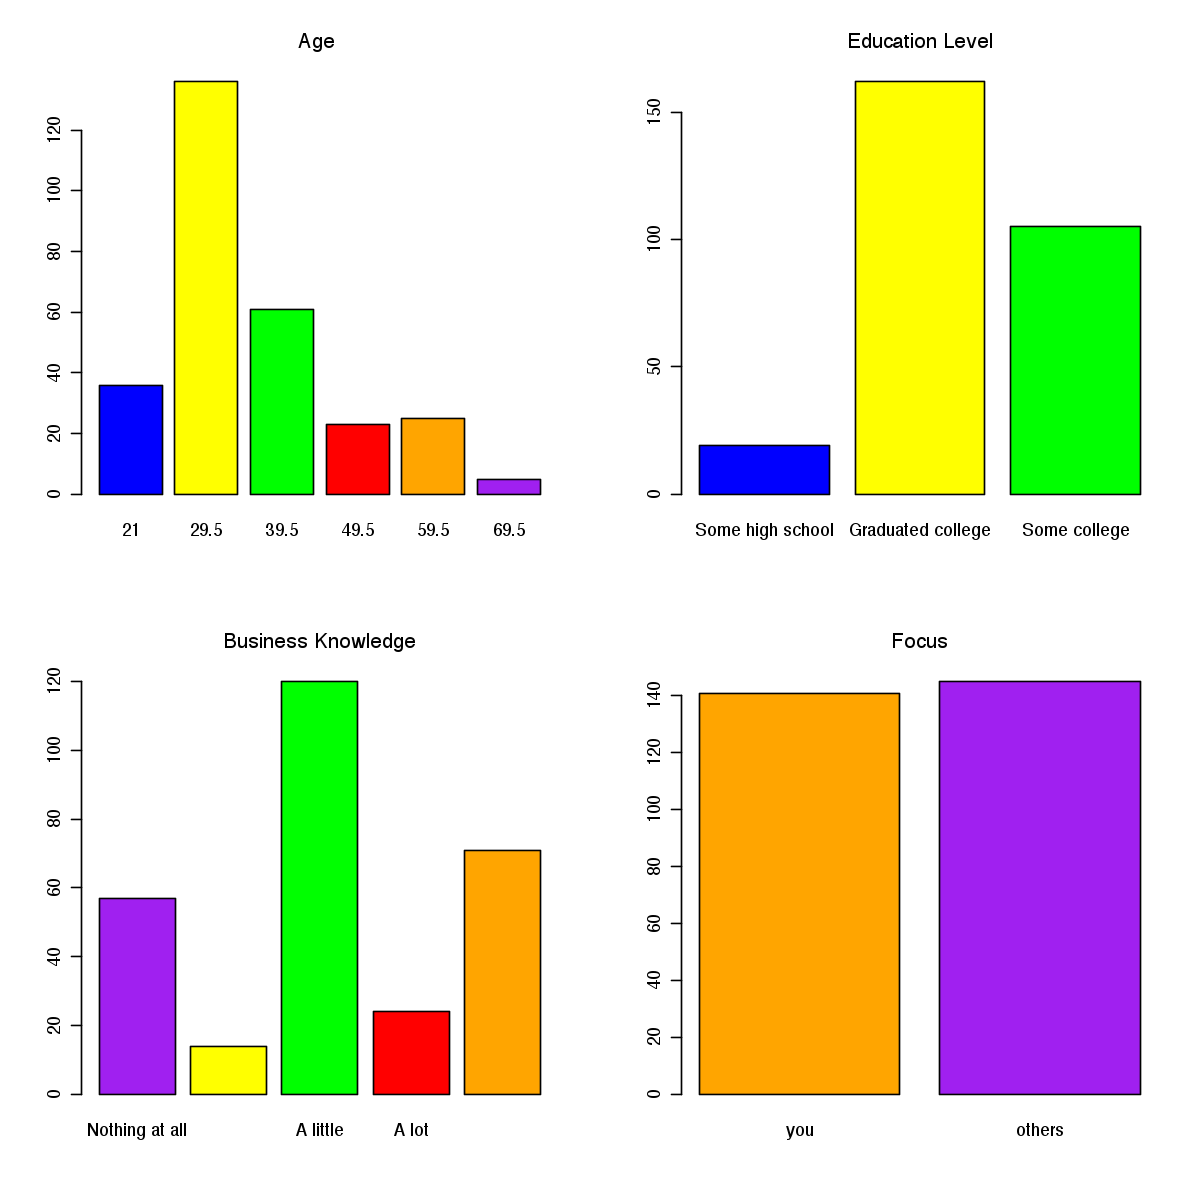

In [11]:
# bar chart for Age, Education level, Business knowledge and survey focus of subjects
options(repr.plot.width=10, repr.plot.height=10)
age <- table(sim.dataset$QID6)
education <- table(sim.dataset$QID7)
buisness <- table(sim.dataset$QID8)
focus <- table(sim.dataset$wording_you_vs_others)

par(mfrow=c(2,2))
barplot(age, main="Age ", col=c("blue","yellow", "green", "red", "orange", "purple" ))
barplot(education, main="Education Level", col=c("blue","yellow", "green", "red", "orange", "purple" ))
barplot(buisness, main="Business Knowledge", col=c("purple","yellow", "green", "red", "orange" ))
barplot(focus, main="Focus", col=c("orange", "purple" ))

##                                                         Average rating of startups

<table border="1" align="left">
<tr>
<td><b>Actual<br>
Name</b>
</td>
<td>Appboy<br>
4.94
</td>
<td>Teespring<br>
5.26
</td>
<td>Lystable<br>
5.32</td>

<td>Lendup<br>
5.05
</td>
<td>Homey<br>
3.66
</td>
<td>Bitgym<br>
5.06
</td>

</tr>



<tr>
<td><b>Nonsense <br>
Name</b>
</td>
<td>Serefly<br>
4.2
</td>
<td>Addepic<br>
4.72
</td>
<td>Sackle<br>
5.35</td>

<td>Grativie<br>
5.4
</td>
<td>Bandity<br>
3.62
</td>
<td>Hacklow <br>
4.32
</td>

</tr>




<tr>
<td><b>Terrible<br>
Name</b>
</td>
<td>CatRash<br>
4.21
</td>
<td>VomitStain<br>
3.32
</td>
<td>Tablebum<br>
5.32</td>

<td>LoanShark<br>
5.01
</td>
<td>DoodyCalls<br>
3.69
</td>
<td>TortureTour <br>
4.55
</td>

</tr>


</table>





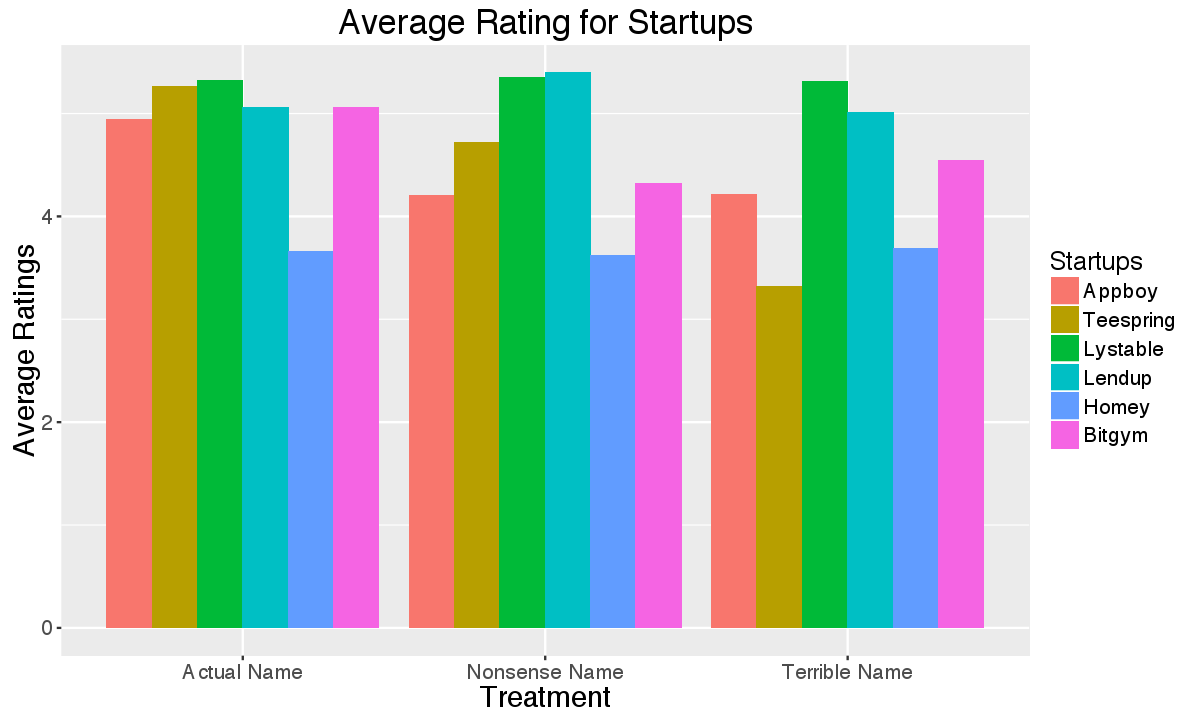

In [17]:
# create treatment indicator for startups
startups.dataset <-startups.dataset[, appboy_treatment := ifelse(appboy_name =="Appboy",
                                                       0,
                                                       ifelse(appboy_name =="Serefly", 1, 2)) ]
startups.dataset <-startups.dataset[, appboy_treatment := as.integer(appboy_treatment)]

startups.dataset <-startups.dataset[, bitgym_treatment := ifelse(bitgym_name =="BitGym",
                                                       0,
                                                       ifelse(bitgym_name =="Hacklow", 1, 2)) ]
startups.dataset <-startups.dataset[, bitgym_treatment := as.integer(bitgym_treatment)]
startups.dataset <-startups.dataset[, homey_treatment := ifelse(homey_name =="Homey",
                                                      0,
                                                      ifelse(homey_name =="Bandity", 1, 2)) ]
startups.dataset <-startups.dataset[, homey_treatment := as.integer(homey_treatment)]

startups.dataset <-startups.dataset[, lendup_treatment := ifelse(lendup_name =="LendUp",
                                                       0,
                                                       ifelse(lendup_name =="Grativie", 1, 2)) ]
startups.dataset <-startups.dataset[, lendup_treatment := as.integer(lendup_treatment)]

startups.dataset <-startups.dataset[, lystable_treatment := ifelse(lystable_name =="Lystable",
                                                         0,
                                                         ifelse(lystable_name =="Sackle", 1, 2)) ]
startups.dataset <-startups.dataset[, lystable_treatment := as.integer(lystable_treatment)]

startups.dataset <-startups.dataset[, teespring_treatment := ifelse(teespring_name =="Teespring",
                                                          0,
                                                          ifelse(teespring_name =="Addepic", 1, 2)) ]
startups.dataset <-startups.dataset[, teespring_treatment := as.integer(teespring_treatment)]

# estimate mean rating gor each startup by treatment
Appboy <- startups.dataset[,  .(Appboy=mean(QID24)), by = .(treatment =appboy_treatment)]
Teespring <- startups.dataset[,  .(Teespring=mean(QID25)), by = . (treatment= teespring_treatment)]
Lystable <- startups.dataset[,  .(Lystable=mean(QID28)), by = .(treatment =lystable_treatment)]
Lendup <- startups.dataset[,  .(Lendup=mean(QID29)), by = .(treatment =lendup_treatment)]
Homey <- startups.dataset[,  .(Homey=mean(QID30)), by = .(treatment =homey_treatment)]
Bitgym <- startups.dataset[,  .(Bitgym=mean(QID31)), by =  (treatment = bitgym_treatment)]

# sort the mean rating for startups
Appboy <- Appboy[order(treatment),]
Teespring <-Teespring[order(treatment),]
Lystable <-Lystable[order(treatment),]
Lendup <-Lendup[order(treatment),]
Homey <-Homey[order(treatment),]
Bitgym <-Bitgym[order(treatment),]

# create long format for the visualization
options(repr.plot.width=10, repr.plot.height=6)
total.startup <- merge(Appboy, Teespring, by="treatment")
total.startup <- merge(total.startup, Lystable, by="treatment")
total.startup <- merge(total.startup, Lendup, by="treatment") #, homey.mean, 
total.startup <- merge(total.startup, Homey, by="treatment")
total.startup <- merge(total.startup, Bitgym, by="treatment")

new.df<-melt(total.startup,id.vars="treatment")

new.df <- new.df[, treatment.type := ifelse(treatment ==0, "Actual Name", ifelse(treatment ==1, "Nonsense Name", "Terrible Name"))]
names(new.df)=c("Treatment","Startups","AverageRatings", "TreatmentType" )

# GG Plot bar chart for average rating for startups
avg.ratings.plot <- ggplot(new.df, aes(x=TreatmentType,y=AverageRatings,fill=Startups))+ geom_bar(stat="identity",position="dodge")   + labs(x="Treatment", y="Average Ratings", title="Average Ratings for Startups")
avg.ratings.plot <-avg.ratings.plot+theme(axis.text=element_text(size=12), axis.title=element_text(size=14,face="bold"))
avg.ratings.plot <- avg.ratings.plot + ggtitle("Average Rating for Startups") + theme(plot.title = element_text(lineheight=3, face="bold", color="black", size=20))
avg.ratings.plot <- avg.ratings.plot + theme(axis.title.y = element_text(size = rel(1.2), angle = 90))
avg.ratings.plot <- avg.ratings.plot + theme(axis.title.x = element_text(size = rel(1.2), angle = 00))
avg.ratings.plot <- avg.ratings.plot+ theme(legend.text=element_text(size=12)) + theme(legend.title=element_text(size=15)) 
avg.ratings.plot
ggsave("./averageratings.png", width = 18, height = 14)

# Estimating the models

## Regression Model 1 - without covariates

In [12]:
# regression model 1 - without covariates
model.1.no.covariates <- lm(rating ~ nonsense_indicator + terrible_indicator + appboy_indicator + 
                            teespring_indicator + lystable_indicator + lendup_indicator + homey_indicator, 
                            data = sim.dataset.m1)

stargazer(model.1.no.covariates, ci=FALSE, type = "text")


                        Dependent variable:    
                    ---------------------------
                              rating           
-----------------------------------------------
nonsense_indicator            -0.276*          
                              (0.157)          
                                               
terrible_indicator           -0.517***         
                              (0.155)          
                                               
appboy_indicator              -0.200           
                              (0.219)          
                                               
teespring_indicator           -0.196           
                              (0.219)          
                                               
lystable_indicator           0.686***          
                              (0.219)          
                                               
lendup_indicator              0.515**          
                              (0.219)  

## Regression Model 2 - with covariates but no funds

In [13]:
# regression model 2 - with covariates but no funds
model.2.with.covariates.no.funds <-  lm(rating ~ nonsense_indicator + terrible_indicator  + Focus + 
                                    appboy_indicator + teespring_indicator + lystable_indicator + 
                                    lendup_indicator + homey_indicator + 
                                    Age  + I(Age^2)  + Education.Level  + Business.Knowledge 
                                  , data = sim.dataset.m1)

stargazer(model.2.with.covariates.no.funds, ci=FALSE, type = "text")


                                        Dependent variable:    
                                    ---------------------------
                                              rating           
---------------------------------------------------------------
nonsense_indicator                            -0.290*          
                                              (0.157)          
                                                               
terrible_indicator                           -0.533***         
                                              (0.155)          
                                                               
Focusothers                                    0.042           
                                              (0.128)          
                                                               
appboy_indicator                              -0.200           
                                              (0.219)          
                                       

## Regression Model 3 - Full Model with covariates

In [30]:
# full model with covariates
full.model.3.with.covariates <-  lm(rating ~ nonsense_indicator + terrible_indicator + funding_in_dollars + 
                                    (nonsense_indicator * funding_in_dollars) + (terrible_indicator * funding_in_dollars )
                                     + funding_natural_log +   (nonsense_indicator * funding_natural_log) + (terrible_indicator * funding_natural_log ) 
                                     + Focus + appboy_indicator + teespring_indicator + lystable_indicator + lendup_indicator + homey_indicator
                                     + Age  + I(Age^2) + Education.Level  + Business.Knowledge 
                                    , data = sim.dataset.m1)

stargazer(full.model.3.with.covariates, ci=FALSE, type = "text" )


                                           Dependent variable:    
                                       ---------------------------
                                                 rating           
------------------------------------------------------------------
nonsense_indicator                               -0.339           
                                                 (0.211)          
                                                                  
terrible_indicator                              -0.630***         
                                                 (0.210)          
                                                                  
funding_in_dollars                               -0.000           
                                                (0.00000)         
                                                                  
funding_natural_log                             0.079***          
                                                 (0.018)     

In [31]:
summary(full.model.3.with.covariates)


Call:
lm(formula = rating ~ nonsense_indicator + terrible_indicator + 
    funding_in_dollars + (nonsense_indicator * funding_in_dollars) + 
    (terrible_indicator * funding_in_dollars) + funding_natural_log + 
    (nonsense_indicator * funding_natural_log) + (terrible_indicator * 
    funding_natural_log) + Focus + appboy_indicator + teespring_indicator + 
    lystable_indicator + lendup_indicator + homey_indicator + 
    Age + I(Age^2) + Education.Level + Business.Knowledge, data = sim.dataset.m1)

Residuals:
   Min     1Q Median     3Q    Max 
 -6.69  -1.75   0.12   1.67   7.20 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                             4.49e+00   7.23e-01    6.21  6.9e-10
nonsense_indicator                     -3.39e-01   2.11e-01   -1.61  0.10843
terrible_indicator                     -6.30e-01   2.10e-01   -3.00  0.00276
funding_in_dollars                     -3.05e-09   1.97e-08   -0.15  0.87704
funding_n

### Regression Model 4 - Full Model with covariates and fixed effect for participants 

In [29]:
#full model with covariates and fixed effect for participants
full.model.4.with.covariates.and.participant.id <-  lm(rating ~ nonsense_indicator + terrible_indicator 
                                                    + funding_in_dollars + (nonsense_indicator * funding_in_dollars) + (terrible_indicator * funding_in_dollars )
                                                    + funding_natural_log + (nonsense_indicator * funding_natural_log) + (terrible_indicator * funding_natural_log ) 
                                                    + Focus + appboy_indicator + teespring_indicator + lystable_indicator + lendup_indicator + homey_indicator
                                                    + Age  + I(Age^2) + Education.Level  + Business.Knowledge + random_code
                                                   , data = sim.dataset.m1)

stargazer(full.model.4.with.covariates.and.participant.id, ci=FALSE, type = "text")


                                           Dependent variable:    
                                       ---------------------------
                                                 rating           
------------------------------------------------------------------
nonsense_indicator                               -0.404*          
                                                 (0.216)          
                                                                  
terrible_indicator                              -0.744***         
                                                 (0.216)          
                                                                  
funding_in_dollars                                0.000           
                                                (0.00000)         
                                                                  
funding_natural_log                             0.086***          
                                                 (0.018)     

In [32]:
summary(full.model.4.with.covariates.and.participant.id )


Call:
lm(formula = rating ~ nonsense_indicator + terrible_indicator + 
    funding_in_dollars + (nonsense_indicator * funding_in_dollars) + 
    (terrible_indicator * funding_in_dollars) + funding_natural_log + 
    (nonsense_indicator * funding_natural_log) + (terrible_indicator * 
    funding_natural_log) + Focus + appboy_indicator + teespring_indicator + 
    lystable_indicator + lendup_indicator + homey_indicator + 
    Age + I(Age^2) + Education.Level + Business.Knowledge + random_code, 
    data = sim.dataset.m1)

Residuals:
   Min     1Q Median     3Q    Max 
-6.859 -1.488  0.025  1.463  7.891 

Coefficients: (9 not defined because of singularities)
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                            -1.77e+00   8.52e+00   -0.21  0.83552
nonsense_indicator                     -4.04e-01   2.16e-01   -1.87  0.06221
terrible_indicator                     -7.44e-01   2.16e-01   -3.45  0.00058
funding_in_dollars        

### All the four regression models compared to each other

In [33]:
# all the four regression models
stargazer(model.1.no.covariates, model.2.with.covariates.no.funds, full.model.3.with.covariates, full.model.4.with.covariates.and.participant.id, 
          type = "text",
          omit.stat = "f",
          ci=FALSE
         )


                                                                 Dependent variable:                          
                                       -----------------------------------------------------------------------
                                                                       rating                                 
                                              (1)               (2)               (3)               (4)       
--------------------------------------------------------------------------------------------------------------
nonsense_indicator                          -0.276*           -0.290*           -0.339            -0.404*     
                                            (0.157)           (0.157)           (0.211)           (0.216)     
                                                                                                              
terrible_indicator                         -0.517***         -0.533***         -0.630***         -0.744***    


### Beta parameter estimates of the nonsense and terrible names

In [21]:
# change plot size to 15 x 10
options(repr.plot.width=15, repr.plot.height=10)

betas <- read.csv(file='./results.csv',sep=',',header=T)

betas <- melt(betas,id.vars="Models")
names(betas)=c("Models","Treatment", "beta" )

betas <- data.table(betas)
betas <- betas[, std.error:= c(0.157, 0.157, 0.211, 0.171, 0.155, 0.155, 0.210, 0.169)]


avg.ratings.plot <- ggplot(betas, aes(x=Models,y=beta,fill=Treatment))+ geom_bar(stat="identity",position="dodge")   + labs(x="Regression Models", y="Beta parameter", title="")
avg.ratings.plot <-avg.ratings.plot+theme(axis.text=element_text(size=12), axis.title=element_text(size=14,face="bold"))
avg.ratings.plot <-avg.ratings.plot+ geom_errorbar(aes(ymin=beta-1.96*std.error, ymax=beta+1.96*std.error),
                                                   width=.2,                    # Width of the error bars
                                                   position=position_dodge(.9))
avg.ratings.plot <- avg.ratings.plot + theme(axis.title.y = element_text(size = rel(1.8), angle = 90))
avg.ratings.plot <- avg.ratings.plot + theme(axis.title.x = element_text(size = rel(1.8), angle = 00))
avg.ratings.plot <- avg.ratings.plot+ theme(legend.text=element_text(size=12)) + theme(legend.title=element_text(size=15))

#avg.ratings.plot
ggsave("./betas.png", width = 18, height = 14)

                   
   <BR>

<div class="image123">
    <div class="imgContainer">
        <img src="./betas.png" height="600" width="1000"/>
    </div>
   
</div>

### Funding level relationship with average change in startup rating

<table border="1" align="left">
<tr>
<td><b>Funding level</b> </td>
<td><b>Average change in rating</b> </td>
</tr>

<tr>
<td>$0</td>
<td>0</td>
</tr>

<tr>
<td>$100,000</td>
<td>0.912</td>
</tr>

<tr>
<td>$500,000</td>
<td>1.04</td>
</tr>

<tr>
<td>$1 million</td>
<td>1.09</td>
</tr>


<tr>
<td>$2 million</td>
<td>1.14</td>
</tr>

<tr>
<td>$5 million</td>
<td>1.21</td>
</tr>

<tr>
<td>$10 million</td>
<td>1.25</td>
</tr>

<tr>
<td>$25 million</td>
<td>1.27</td>
</tr>


</table>


### Subjects' response to question "What do you think we are going to do with your survey responses?"

In [19]:
startups.dataset[(1:20), .(subject_response=QID49_TEXT)]

,subject_response
1,No idea
2,Compare them to others' answers
3,No idea!
4,compare them with the actual performance of real startup companies to see how effective human intuition is at predicting the future success of a startup business
5,They were probably renamed and going to use money to invest in startups that we answered for.
6,Create a spreadsheet or graphic chart
7,See what people think of the various startup investment options.
8,Compare and see which ideas are most popular
9,Record data
10,unsure
